# Prostate158 dataset exploration

In [2]:
import os
from os.path import join
import sys
sys.path.append("../")
import matplotlib.pyplot as plt
import random
import pandas as pd
import SimpleITK as sitk
import numpy as np

from exploratoryAnalysis.DataAnalyzer import DataAnalyzer
from time import perf_counter

DATA_ROOT = "/home/guest/work/Datasets"

paths = {
    "158_train" : "prostate158/prostate158_train/train",
    "158_test" : "prostate158/prostate158_test/test"
}

analyzer = DataAnalyzer(DATA_ROOT)


> Every patient case will at least have three imaging sequences: axial T2W, axial DWI and axial ADC scans (i.e. files ending in _t2w.mha, _hbv.mha, _adc.mha). Additionally, they can also have either, both or none of these optional imaging sequences: sagittal and coronal T2W scans (i.e. files ending in _sag.mha, _cor.mha here). 

Let's see what's inside each patient's dir

In [3]:
def dirs_by_file_count(pth):
    """
    Returns a dictionary where keys are the number of files in each directory
    and values are lists of directories with that number of files.
    """
    
    bins = dict()
    total = 0

    for dir in analyzer.get_dirs(pth):
        # check if they all have 5 files
        rel = os.path.join(pth, dir)
        
        files = analyzer.get_files(rel)
        key = len(list(files))
        
        # ensure the key exists 
        if key not in bins:
            bins[key] = []
        
        bins[key].append(dir)
        total += 1

    print(f"Processed {total} dirs")

    return bins



Processed 139 dirs


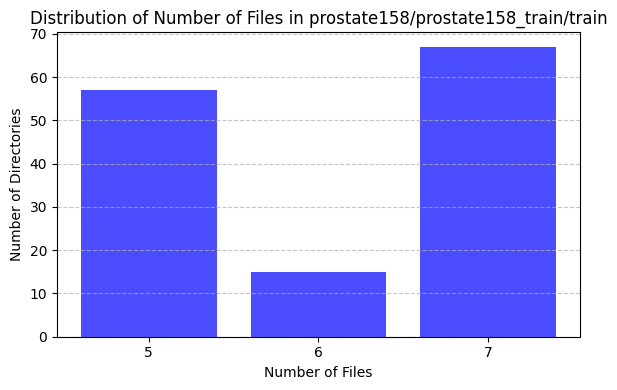

In [4]:
# plot the previous bins
pth = os.path.join(paths["158_train"])
bins = dirs_by_file_count(pth)

plt.figure(figsize=(6, 4))
plt.bar(bins.keys(), [len(v) for v in bins.values()], color='blue', alpha=0.7)
plt.xlabel('Number of Files')
plt.ylabel('Number of Directories')
plt.title(f'Distribution of Number of Files in {pth}')
plt.xticks(list(bins.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

Processed 19 dirs


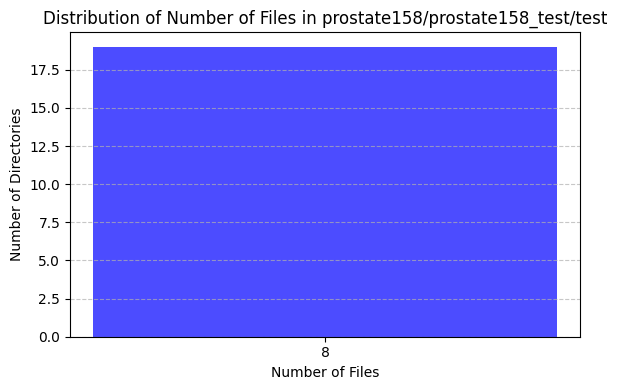

In [5]:
# plot the previous bins
pth = os.path.join(paths["158_test"])
bins = dirs_by_file_count(pth)

plt.figure(figsize=(6, 4))
plt.bar(bins.keys(), [len(v) for v in bins.values()], color='blue', alpha=0.7)
plt.xlabel('Number of Files')
plt.ylabel('Number of Directories')
plt.title(f'Distribution of Number of Files in {pth}')
plt.xticks(list(bins.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

Some dirs in the train set are missing. The differences in files are due to the extra reader in the test files. In train some have reads for tumors / an empty nii.gz file, but all t2w images and t2w reads (labels).

Now, we plot some of the images. We also need to see how each zone is labeled. (pz=1 or 2, tz=1 or 2, etc.)

**As we see, the TZ is labeled as 2 and the PZ as 1.**

<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_3663146/2708784779.py:5: SyntaxWarning: invalid escape sequence '\.'
  files_in_dir = analyzer.get_files(join(d, random_dir), "(t2\..*)|(t2_anatomy.*)")


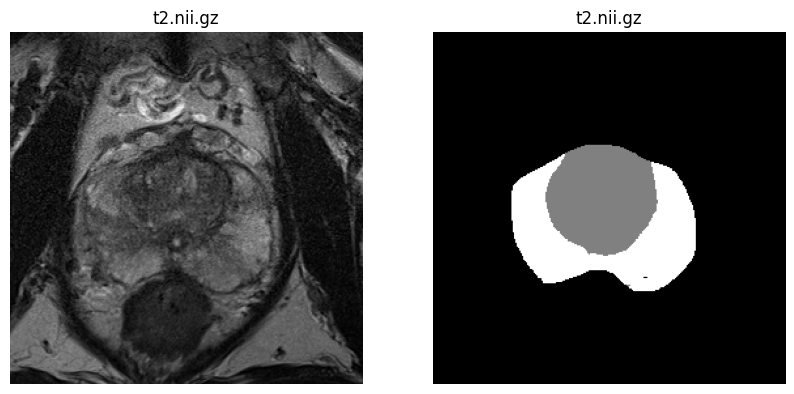

In [6]:
# pick a random folder and set the name of a file inside as the prefix
d = paths["158_train"]
dirs = list(analyzer.get_dirs(d))
random_dir = random.choice(dirs)
files_in_dir = analyzer.get_files(join(d, random_dir), "(t2\..*)|(t2_anatomy.*)")

# we have to do this because get files is a generator
name = list(files_in_dir)
i1 = join(d, random_dir, name[0])
i2 = join(d, random_dir, name[1])

analyzer.show_image(i1, i2, save="../combined_images.png")

Let's look for possible empty masks, since some of the lesion data was missing

In [7]:
train = paths['158_train']

# Check for empty masks in the training set
non_empty_count = 0
empty_masks = []
for dir in analyzer.get_dirs(train):
    
    name = analyzer.get_files(join(train, dir), "t2_anatomy.*")
    mask_path = join(train, dir, list(name)[0])
    
    # Check if the mask is empty
    if analyzer.is_empty_mask(mask_path):
        print("hello")
        empty_masks.append(mask_path)
    else:
        non_empty_count += 1

print(f"{non_empty_count} out of {non_empty_count+len(empty_masks)} masks are non-empty (contain a segmentation).")
print("Empty mask files:", empty_masks)

139 out of 139 masks are non-empty (contain a segmentation).
Empty mask files: []


Now, we use the function the analyzer to analyze the metadata.

In [8]:
# use this regex to filter the files
analyzer.regex = "t2.nii.gz"

start = perf_counter()
df = analyzer.collect_metadata_from_subdirs(paths['158_train'])
print(df)
print(perf_counter() - start, "seconds")

Error decoding line in /home/guest/work/Datasets/prostate158/prostate158_train/train/064/t2.nii.gz: b'\x1f\x8b\x08\x00\x00\x00\x00\x00\x00\x03\xb4\xbdo\xbcV'...
Error decoding line in /home/guest/work/Datasets/prostate158/prostate158_train/train/121/t2.nii.gz: b'\x1f\x8b\x08\x00\x00\x00\x00\x00\x00\x03\xb4\xbd\x7f|\xd5'...Error decoding line in /home/guest/work/Datasets/prostate158/prostate158_train/train/063/t2.nii.gz: b'\x1f\x8b\x08\x00\x00\x00\x00\x00\x00\x03\xb4\xbd\x7fl\x9d'...

Error decoding line in /home/guest/work/Datasets/prostate158/prostate158_train/train/062/t2.nii.gz: b'\x1f\x8b\x08\x00\x00\x00\x00\x00\x00\x03\xb4\xbd\x7f|^'...
Error decoding line in /home/guest/work/Datasets/prostate158/prostate158_train/train/097/t2.nii.gz: b'\x1f\x8b\x08\x00\x00\x00\x00\x00\x00\x03\xb4\xbdk\xbcU'...
Error decoding line in /home/guest/work/Datasets/prostate158/prostate158_train/train/075/t2.nii.gz: b'\x1f\x8b\x08\x00\x00\x00\x00\x00\x00\x03\xb4\xbd}\xbc\x96'...
Error decoding line in /h

This dataset has significantly no extra metadata information, apart from image dims

In [9]:
print(df)

      filename        dim_size              spacing orientation  \
0    t2.nii.gz  (270, 270, 24)  (0.402, 0.402, 3.0)        None   
1    t2.nii.gz  (442, 442, 31)  (0.272, 0.272, 3.0)        None   
2    t2.nii.gz  (270, 270, 26)  (0.402, 0.402, 3.0)        None   
3    t2.nii.gz  (270, 270, 26)  (0.402, 0.402, 3.0)        None   
4    t2.nii.gz  (270, 270, 26)  (0.402, 0.402, 3.0)        None   
..         ...             ...                  ...         ...   
134  t2.nii.gz  (442, 442, 25)  (0.272, 0.272, 3.0)        None   
135  t2.nii.gz  (442, 442, 25)  (0.272, 0.272, 3.0)        None   
136  t2.nii.gz  (270, 270, 26)  (0.402, 0.402, 3.0)        None   
137  t2.nii.gz  (270, 270, 24)  (0.402, 0.402, 3.0)        None   
138  t2.nii.gz  (270, 270, 24)  (0.402, 0.402, 3.0)        None   

    prostate_volume vendor mri_name psa_report  
0              None   None     None       None  
1              None   None     None       None  
2              None   None     None       None  

Now, we are interested in the dimensons and resolutions of the data, and how they are distrubuted trough the dataset.

This dataset also does not provide several anatomical orientations (axial, sagital, coronal).

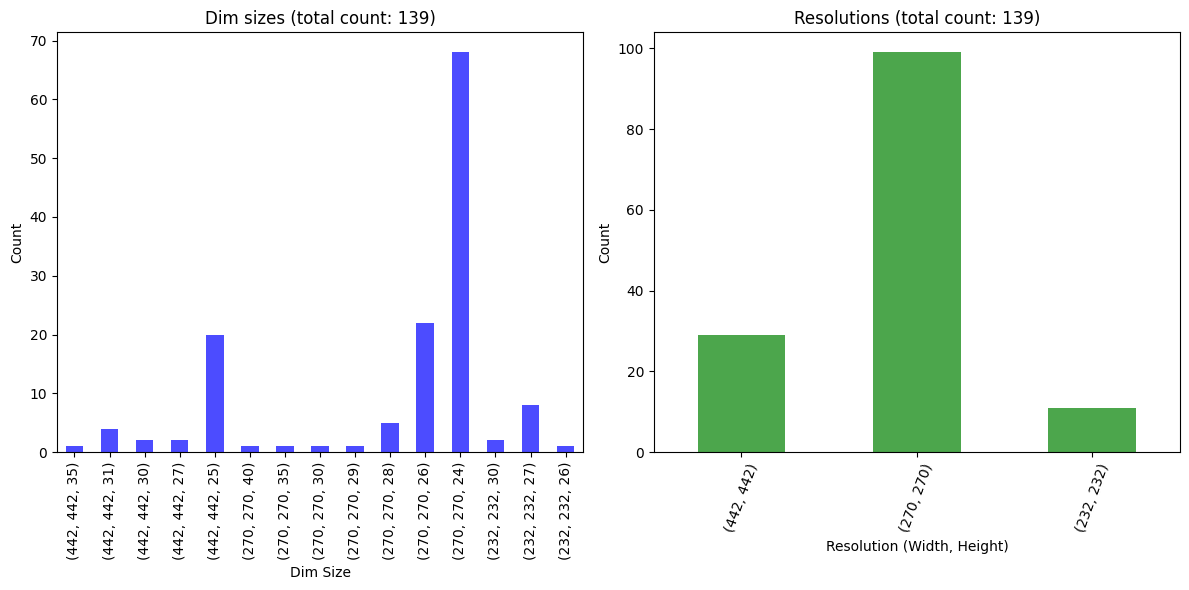

In [10]:
    
# Obtener el conteo de dim_size y ordenarlo
dim_sizes = df['dim_size'].value_counts().sort_index(ascending=False)

# Agrupar por resolución (ancho, alto) ignorando la profundidad
resolution_counts = (
    df['dim_size']
    .apply(lambda x: (x[0], x[1]))  # Extraer solo (ancho, alto)
    .value_counts()
    .sort_index(ascending=False)
)

# Crear dos gráficos separados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Dos gráficos lado a lado

# Primer gráfico: dim_size
dim_sizes.plot(kind='bar', ax=ax1, color='blue', alpha=0.7)
ax1.set_title(f"Dim sizes (total count: {dim_sizes.sum()})")
ax1.set_xlabel("Dim Size")
ax1.set_ylabel("Count")
ax1.tick_params(axis='x', rotation=90)

# Segundo gráfico: resolución (ancho, alto)
resolution_counts.plot(kind='bar', ax=ax2, color='green', alpha=0.7)
ax2.set_title(f"Resolutions (total count: {resolution_counts.sum()})")
ax2.set_xlabel("Resolution (Width, Height)")
ax2.set_ylabel("Count")
ax2.tick_params(axis='x', rotation=70)

plt.tight_layout()  # Ajustar el diseño para evitar solapamientos
plt.show()

Similar as before but with image voxel spacing.

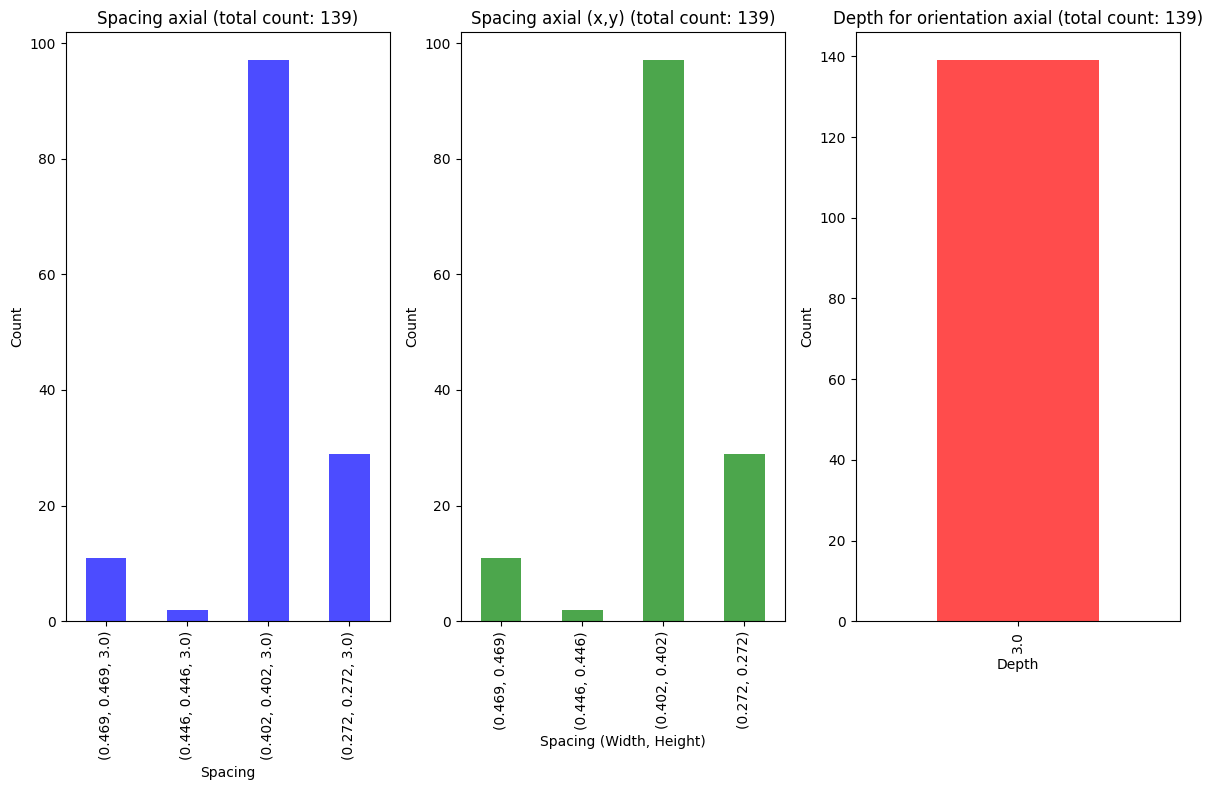

In [11]:

value = "axial"
    
dim_sizes = df['spacing'].value_counts().sort_index(ascending=False)

# Agrupar por resolución (ancho, alto) ignorando la profundidad
resolution_counts = (
    df['spacing']
    .apply(lambda x: (x[0], x[1]))  # Extraer solo (ancho, alto)
    .value_counts()
    .sort_index(ascending=False)
)

# agrupar por la profundidad de la imagen
depth_counts = (
    df['spacing']
    .apply(lambda x: (x[2]))  # Extraer solo la profundidad
    .value_counts()
    .sort_index(ascending=False)
)


# Crear dos gráficos separados
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8))  # Dos gráficos lado a lado

# Primer gráfico: dim_size
dim_sizes.plot(kind='bar', ax=ax1, color='blue', alpha=0.7)
ax1.set_title(f"Spacing {value} (total count: {dim_sizes.sum()})")
ax1.set_xlabel("Spacing")
ax1.set_ylabel("Count")
ax1.tick_params(axis='x', rotation=90)

# Segundo gráfico: resolución (ancho, alto)
resolution_counts.plot(kind='bar', ax=ax2, color='green', alpha=0.7)
ax2.set_title(f"Spacing {value} (x,y) (total count: {resolution_counts.sum()})")
ax2.set_xlabel("Spacing (Width, Height)")
ax2.set_ylabel("Count")
ax2.tick_params(axis='x', rotation=90)

# Tercer gráfico: profundidad
depth_counts.plot(kind='bar', ax=ax3, color='red', alpha=0.7)
ax3.set_title(f"Depth for orientation {value} (total count: {depth_counts.sum()})")
ax3.set_xlabel("Depth")
ax3.set_ylabel("Count")
ax3.tick_params(axis='x', rotation=90)

plt.tight_layout()  # Ajustar el diseño para evitar solapamientos
plt.show()

We must also check the image pixel intensities for normalization.

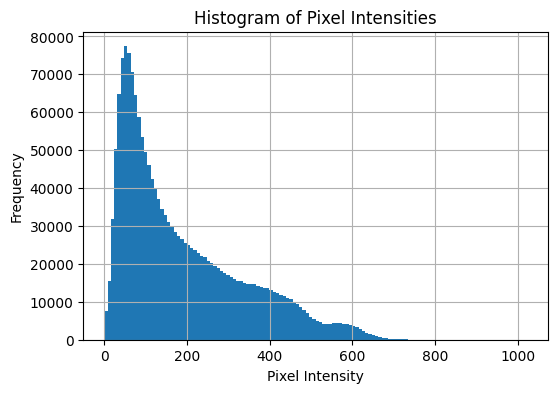

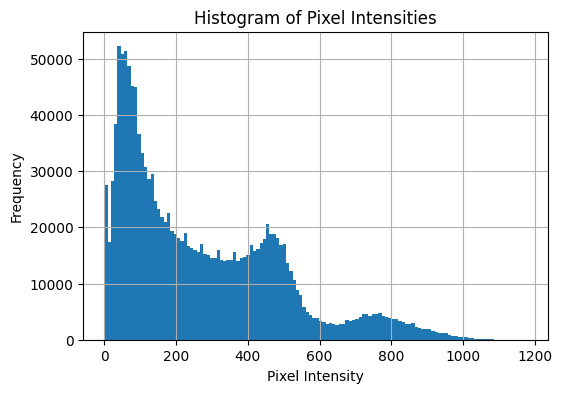

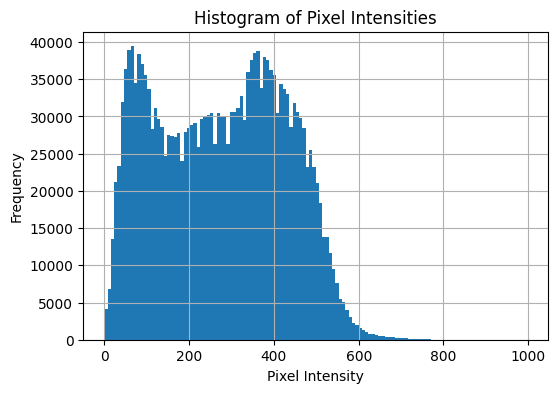

In [12]:
d = paths["158_train"]
dirs = list(analyzer.get_dirs(d))
random_dir = random.choices(dirs, k=3)


for idx, dir in enumerate(random_dir):
    files_in_dir = analyzer.get_files(join(d, dir), "t2.nii.gz")

    # We have to do this because get_files is a generator
    name = list(files_in_dir)[0]
    i1 = join(d, dir, name)

    analyzer.image_intensity_histogram(i1, plot = True)   

In [13]:
interr = join(DATA_ROOT, "prostate158/interrater.csv")

df = pd.read_csv(interr)
df

,ID,dice_interrater_tz,dice_interrater_pz,dice_interrater_tu,hausdorff_interrater_tz,hausdorff_interrater_pz,hausdorff_interrater_tu,surface_interrater_tz,surface_interrater_pz,surface_interrater_tu,tz_mean_vol_reader1,pz_mean_vol_reader1,tu_mean_vol_reader1,tz_mean_vol_reader2,pz_mean_vol_reader2,tu_mean_vol_reader2
0,1,0.846485,0.778402,0.634169,10.099505,7.810250,16.155494,1.082743,0.811016,1.933039,37.668,33.044,1.938,38.334,38.048,1.101
1,2,0.912788,0.708775,0.000000,8.717798,14.282857,50.338852,0.572738,0.542160,27.271049,41.587,13.130,0.797,42.934,18.572,0.334
2,3,0.918346,0.763188,0.864965,11.832160,24.372115,6.782330,0.777702,0.386071,0.228150,77.437,13.791,2.618,77.904,18.406,2.994
3,4,0.857938,0.724157,0.442276,8.944272,15.937377,24.186773,1.017524,0.969512,6.120263,28.347,12.526,0.807,26.369,14.404,0.409
4,5,0.907351,0.816965,0.778924,6.324555,11.045361,12.884099,0.875773,0.506066,0.628945,55.293,17.495,9.046,55.250,21.951,10.571
5,6,0.890938,0.780360,0.761513,7.000000,12.569805,12.206556,0.804702,0.626561,0.852717,29.604,16.728,12.112,31.363,17.762,14.312
6,7,0.901301,0.769519,0.055215,13.038405,17.691806,16.401219,1.246122,0.597211,3.488547,43.478,14.903,0.633,38.923,20.624,0.871
7,8,0.871135,0.669747,0.688969,10.000000,10.816654,5.000000,0.992575,0.604556,0.585485,27.223,11.538,0.659,26.497,20.278,0.800
8,9,0.833615,0.791664,0.324524,8.602325,8.602325,29.086079,1.178235,0.756059,6.285089,14.635,13.236,1.305,12.630,15.673,1.015
9,10,0.856498,0.792155,0.847754,14.525839,43.737855,15.297059,0.969314,1.555847,0.607915,41.627,42.766,21.237,44.277,42.034,24.259


We'll explore now the extents of the prostate in each image.

We need this information to stablish how much we can center-crop the images without losing any / much information.

In [14]:
import concurrent.futures
# we use concurrency te prevent too many sequential reads of the files which can be slow

parent_dir = join(DATA_ROOT, paths["158_train"])
analyzer.regex = "t2_anatomy_reader"
cpus = os.cpu_count()

with concurrent.futures.ProcessPoolExecutor(
    max_workers=cpus
) as executor:
    records = list(
        executor.map(analyzer.calculate_cube_bounds, 
        analyzer.file_paths_gen(parent_dir))
    )
df = pd.DataFrame(records, columns=['start_z', 'end_z', 'start_y', 
                                    'end_y', 'start_x', 'end_x', 'mask_path',
                                    'bounding_box_size', 'proportion_of_image_size'])
df

,start_z,end_z,start_y,end_y,start_x,end_x,mask_path,bounding_box_size,proportion_of_image_size
0,0,24,70,201,70,201,/home/guest/work/Datasets/prostate158/prostate...,131,0.485185
1,0,31,101,342,101,342,/home/guest/work/Datasets/prostate158/prostate...,241,0.545249
2,0,26,54,217,54,217,/home/guest/work/Datasets/prostate158/prostate...,163,0.603704
3,0,26,37,234,37,234,/home/guest/work/Datasets/prostate158/prostate...,197,0.729630
4,0,26,77,194,77,194,/home/guest/work/Datasets/prostate158/prostate...,117,0.433333
...,...,...,...,...,...,...,...,...,...
134,0,25,107,336,107,336,/home/guest/work/Datasets/prostate158/prostate...,229,0.518100
135,0,25,113,330,113,330,/home/guest/work/Datasets/prostate158/prostate...,217,0.490950
136,0,26,72,199,72,199,/home/guest/work/Datasets/prostate158/prostate...,127,0.470370
137,0,24,49,222,49,222,/home/guest/work/Datasets/prostate158/prostate...,173,0.640741


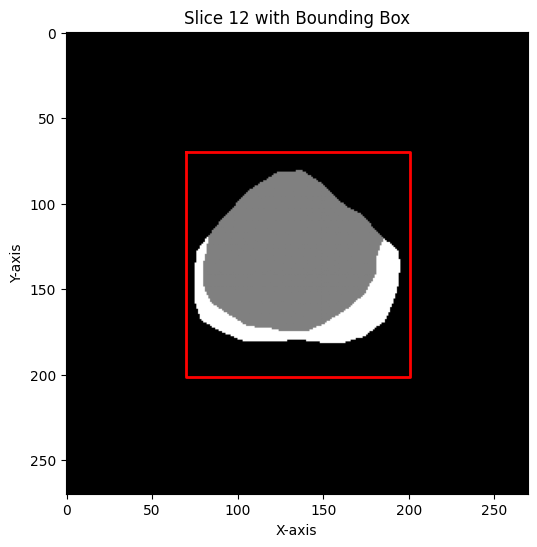

In [15]:
import random
import matplotlib.pyplot as plt

# pick a random number in the range of the dataframe and display the bounding box for the image
random_index = random.randint(0, len(df) - 1)
start_z, end_z, start_y, end_y, start_x, end_x, mask_path,\
    bounding_box_size, proportion_of_image_size = df.iloc[random_index]

mask = sitk.ReadImage(mask_path)
mask_array = sitk.GetArrayFromImage(mask)

analyzer.overlay_bounding_box(mask_array, mask_array.shape[0] //2 ,start_y, end_y, start_x, end_x)


In [16]:
from ipywidgets import interact, IntSlider, fixed

# Create a slider to select the slice index
slider = IntSlider(value=mask_array.shape[0] // 2, min=0, max=mask_array.shape[0]-1, step=1, description='Slice Index')
# Use interact to create the interactive bounding box display
# Note: 'fixed' is used to pass fixed values for        
# the bounding box parameters so they don't change with the slider.
interact(analyzer.overlay_bounding_box, mask=fixed(mask_array), slice=slider, start_y=fixed(start_y), end_y=fixed(end_y), start_x=fixed(start_x), end_x=fixed(end_x))


interactive(children=(IntSlider(value=12, description='Slice Index', max=23), Output()), _dom_classes=('widget…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

Now that we have this, and since the bounding box si centered and square, we can calculate easily the distribution of the bounding box sizes in the dataset. 

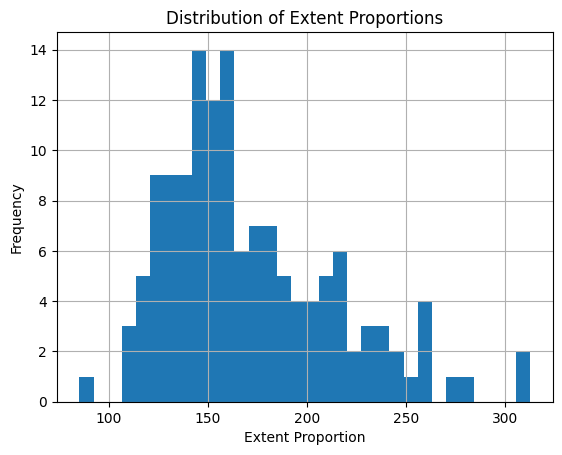

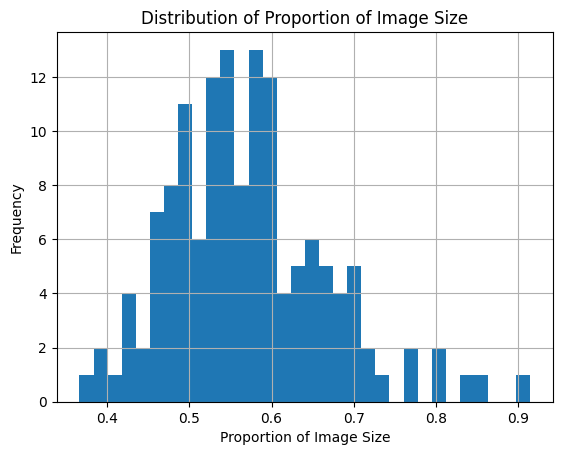

In [17]:
# using 'start_y', 'end_y', 'start_x', 'end_x', calculate the 
# size of the bounding box as the maximum of the width and height, 
# and then calculate the proportion of that wrt the image size, to 
# get a sense of how much we can crop the image


# distribution of extent proportions
df['bounding_box_size'].hist(bins=32)
plt.title("Distribution of Extent Proportions")
plt.xlabel("Extent Proportion")
plt.ylabel("Frequency")
plt.show()

df['proportion_of_image_size'].hist(bins=32)
plt.title("Distribution of Proportion of Image Size")
plt.xlabel("Proportion of Image Size")
plt.ylabel("Frequency")
plt.show()


